In [38]:
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import torchvision
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import ResziePadding

class BLDataset(Dataset):
    def __init__(self, root_dir, transform, is_train=True, imgsz=512, test_rate=0.2):
        self.train=is_train
        self.transform=transform
        self.imgsz=imgsz
        self.root_dir = root_dir
        self.true_imgs=os.listdir(os.path.join(self.root_dir,'true_bl'))
        self.false_imgs=os.listdir(os.path.join(self.root_dir,'false_bl'))
        self.false_train, self.false_test=train_test_split(self.false_imgs, test_size=test_rate, random_state=42)
        self.true_train, self.true_test=train_test_split(self.true_imgs, test_size=test_rate, random_state=42)
        if self.train:
            self.train_data = self.true_train+self.false_train
            self.train_labels = [0]*len(self.true_train)+[1]*len(self.false_train)
            self.labels_set = set([0,1])
            self.label_to_indices = {label: np.where(np.array(self.train_labels) == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_data = self.true_test+self.false_test
            self.test_labels = [0]*len(self.true_test)+[1]*len(self.false_test)
            self.labels_set = set([0,1])
            self.label_to_indices = {label: np.where(np.array(self.test_labels) == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i]]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i]]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

        
    def __len__(self):
        return len(self.true_train)

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index]
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
        
        img1_data=ResziePadding(cv2.cvtColor(cv2.imread(os.path.join(self.root_dir,'images',img1)),cv2.COLOR_BGR2RGB), fixed_side=self.imgsz)
        img2_data=ResziePadding(cv2.cvtColor(cv2.imread(os.path.join(self.root_dir,'images',img2)),cv2.COLOR_BGR2RGB), fixed_side=self.imgsz)
        
        print(img1_data.shape)
        img1 = Image.fromarray(img1_data, mode='RGB')
        img2 = Image.fromarray(img2_data, mode='RGB')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target



(512, 512, 3)
(512, 512, 3)
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])


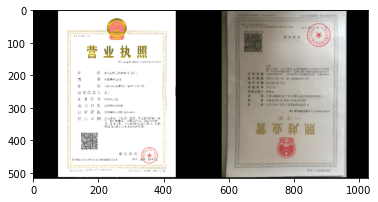

In [52]:
dataset = BLDataset(
        root_dir="/Users/lvhaoran/Downloads/bl-data-for-siamese-network/",
        transform=transforms.Compose([
            transforms.ToTensor(),
           transforms.RandomHorizontalFlip(p=0.1),
           transforms.RandomVerticalFlip(p=0.1),
        ])
    )

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2,shuffle=True)

for inputs, labels in data_loader:
     print(inputs[0].shape)
     print(inputs[1].shape)
     img = torchvision.utils.make_grid(inputs[0])
     img_nm = img.numpy()
     img_trans = np.transpose(img_nm, (1, 2, 0))
     plt.imshow(img_trans)
     plt.show()
     break
